# Closed shell reactions with core correlation

Bak et al., [doi:10.1063/1.1357225](https://doi.org/10.1063/1.1357225) and [doi:10.1063/1.481544](https://doi.org/10.1063/1.481544)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from pysjef import all_completed, DirectoryNode
from pysjef_molpro import no_errors, Project
from shutil import rmtree
from os.path import exists
pd.set_option("display.precision",2)

In [2]:
backend = 'local' # If preferred, change this to one of the backends in your ~/.sjef/molpro/backends.xml that is ssh-accessible
project_name = 'Core_Valence_reactions'
parallel = 7 # how many jobs to run at once

In [3]:
methods = ['HF','MP2','MP3','PAPT2','PAPT3', 'CCSD','MP4','PAPT4', 'CCSD(T)']
bases = ['cc-pCVDZ','cc-pCVTZ','cc-pCVQZ', 'cc-pCV5Z']

In [4]:
closed_shell_methods={'B3LYP' : "ks, b3lyp", "HF" : "hf", "MP2":"mp2","MP3":"mp3","MP4":"mp4","CCSD":"ccsd","CCSD(T)":"ccsd(t)", "PAPT2":"papt;mp2", "PAPT3":"papt;mp3", "PAPT4":"papt;mp4"}

In [5]:
molecules={}
molecules["F2"] = {"De_exp" : 163.35, "De_calc" : 161.04, "geometry" : "F;F,F,1.41134168", "stoichiometry": "FF"}
molecules["H2"] = {"De_exp" : 458.04, "De_calc" : 458.13, "geometry" : "H;H,H,0.74184515", "stoichiometry": "HH"}
molecules["HF"] = {"De_exp" : 593.16, "De_calc" : 593.20, "geometry" : "H;F,H,0.91576748", "stoichiometry": "HF"}
molecules["CH2"] = {"De_exp" : 757.06, "De_calc" : 575.87, "geometry" : "C;H,C,1.10678917;H,C,1.10678917,H,102.02249921", "stoichiometry": "CHH"}
molecules["HNO"] = {"De_exp" : 861.50, "De_calc" : 860.12, "geometry" : "H;N,H,1.05238269;O,N,1.20847128,H,108.08480747", "stoichiometry": "HNO"}
molecules["N2"] = {"De_exp" : 956.28, "De_calc" : 954.68, "geometry" : "N;N,N,1.09811947", "stoichiometry": "NN"}
molecules["H2O"] = {"De_exp" : 975.28, "De_calc" : 975.32, "geometry" : "H;O,H,0.95711647;H,O,0.95711647,H,104.22359713", "stoichiometry": "HHO"}
molecules["CO"] = {"De_exp" : 1086.70, "De_calc" : 1086.70, "geometry" : "C;O,C,1.12887680", "stoichiometry": "CO"}
molecules["H2O2"] = {"De_exp" : 1126.91, "De_calc" : 1125.82, "geometry" : "H1;O1,H1,0.9619;O2,O1,1.4497,H1,99.99;H2,O2,0.9619,O1,99.99,H1,112.7", "stoichiometry": "HHOO"}
molecules["NH3"] = {"De_exp" : 1247.88, "De_calc" : 1247.15, "geometry" : "N1;X,N1,10;H1,N1,1.01116937,X,112.42635522;H2,N1,1.01116937,X,112.42635522,H1,120;H3,N1,1.01116937,X,112.42635522,H2,120", "stoichiometry": "NHHH"}
molecules["HCN"] = {"De_exp" : 1312.75, "De_calc" : 1310.72, "geometry" : "H;C,H,1.06553056;N,C,1.15383982,H,180", "stoichiometry": "HCN"}
molecules["CH2O"] = {"De_exp" : 1566.58, "De_calc" : 1567.78, "geometry" : "C;O,C,1.20430342;H1,C,1.10077162,O,121.78046616;H2,C,1.10077162,O,121.78046616,H1,180", "stoichiometry": "CHHO"}
molecules["CO2"] = {"De_exp" : 1632.46, "De_calc" : 1632.77, "geometry" : "O1;C,O1,1.16039505;O2,C,1.16039505,O1,180", "stoichiometry": "COO"}
molecules["C2H2"] = {"De_exp" : 1697.84, "De_calc" : 1696.81, "geometry" : "H1;C1,H1,1.06209557;C2,C1,1.20366063,H1,180;H2,C2,1.06209557,C1,180,H1,0", "stoichiometry": "CCHH"}
molecules["CH4"] = {"De_exp" : 1759.33, "De_calc" : 1759.30, "geometry" : "C1;H4,C1,1.08637390;H1,C1,1.08637390,H4,109.47122063;H2,C1,1.08637390,H4,109.47122063,H1,120;H3,C1,1.08637390,H4,109.47122063,H2,120", "stoichiometry": "CHHHH"}
molecules["C2H4"] = {"De_exp" : 2359.82, "De_calc" : 2360.55, "geometry" : "C1;C2,C1,1.33117445;H11,C1,1.08089487,C2,121.44926360;H12,C1,1.08089487,C2,121.44926360,H11,180;H21,C2,1.08089487,C1,121.44926360,H11,0;H22,C2,1.08089487,C1,121.44926360,H12,0", "stoichiometry": "CCHHHH"}

In [6]:
def proj(molecule,method,basis):
    return Project((molecule+"--"+method+"--"+basis).replace('(T)','-T'),location=project_name,suffix='molpro')

In [7]:
projects=[]
import os
if not os.path.isdir(project_name): os.mkdir(project_name)
for method in methods:
    for basis in bases:
        for molecule, content in (molecules).items():
            p = proj(molecule,method,basis)
            projects.append(p)
            p.write_input(
            f"""memory,1,g;
angstrom;geometry={{
{content["geometry"]}
}}
basis = {basis}
rhf;{"{mp2;core}" if method != "HF" else ""}
{open_shell_methods[method] if content.get("open_shell") else closed_shell_methods[method]}
            """)

In [8]:
from multiprocessing.dummy import Pool
from operator import methodcaller
with Pool(processes=parallel) as pool:
    pool.map(methodcaller('run', backend=backend, wait=True),
             projects, 1)
print('all completed', all_completed(projects))
print('without errors', no_errors(projects))

for method in methods:
    for basis in bases:
        for name, molecule in (molecules).items():
            if proj(name,method,basis).status == 'failed':
                print("Failed run: ",method, basis, name,proj(name,method,basis).error_messages())

if not (all_completed(projects) and no_errors(projects)):
    assert False

all completed True
without errors True


In [9]:
def get_energy(proj):
    return ([None]+proj.select('//jobstep/property[name=Energy].value') + proj.select('//jobstep/property[name=total energy].value'))[-1]

energies={}
for method in methods:
    energies[method]={}
    for basis in bases:
        energies[method][basis]={}
        for name, molecule in (molecules).items():
            energies[method][basis][name]=get_energy(proj(name,method,basis))

## Extrapolation

In [10]:
extrapolations={}
if 'cc-pCVDZ' in bases and 'cc-pCVTZ' in bases:
    extrapolations["DT"]={'x':2, 'first':'cc-pCVDZ', 'second':'cc-pCVTZ'}
if 'cc-pCVTZ' in bases and 'cc-pCVQZ' in bases:
    extrapolations["TQ"]={'x':3, 'first':'cc-pCVTZ', 'second':'cc-pCVQZ'}
if 'cc-pCVQZ' in bases and 'cc-pCV5Z' in bases:
    extrapolations["Q5"]={'x':4, 'first':'cc-pCVQZ', 'second':'cc-pCV5Z'}

for extr in extrapolations:
    x=extrapolations[extr]['x']
    xbas=extrapolations[extr]['first']
    xpbas=extrapolations[extr]['second']
    for method in methods:
        energies[method][extr]={}
        for molecule in molecules:
            energies[method][extr][molecule] = energies['HF'][xpbas][molecule] + (
                x*x*x*(energies[method][xbas][molecule]-energies['HF'][xbas][molecule])
                -(x+1)*(x+1)*(x+1)*(energies[method][xpbas][molecule]-energies['HF'][xpbas][molecule])
            ) / (x*x*x-(x+1)*(x+1)*(x+1))
    bases.append(extr) if extr not in bases else ""

## Calculated enthalpy changes

In [11]:
reactions={}
reactions["1"] = {"CO" : -1, "H2" : -1, "CH2O" : +1}
reactions["2"] = {"N2" : -1, "H2" : -3, "NH3" : +2}
reactions["3"] = {"C2H2" : -1, "H2" : -1, "C2H4" : +1}
reactions["4"] = {"CO2" : -1, "H2" : -4, "CH4" : +1, "H2O" : +2}
reactions["5"] = {"CH2O" : -1, "H2" : -2, "CH4" : +1, "H2O" : +1}
reactions["6"] = {"CO" : -1, "H2" : -3, "CH4" : +1, "H2O" : +1}
reactions["7"] = {"HCN" : -1, "H2" : -3, "CH4" : +1, "NH3" : +1}
reactions["8"] = {"H2O2" : -1, "H2" : -1, "H2O" : +2}
reactions["9"] = {"HNO" : -1, "H2" : -2, "H2O" : +1, "NH3" : +1}
reactions["10"] = {"C2H2" : -1, "H2" : -3, "CH4" : +2}
reactions["11"] = {"CH2" : -1, "H2" : -1, "CH4" : +1}
reactions["12"] = {"F2" : -1, "H2" : -1, "HF" : +2}
reactions["13"] = {"CH2" : -2, "C2H4" : +1}

In [12]:
Molpro_enthalpy={}
for method in methods:
    Molpro_enthalpy[method]={}
    for basis in bases:
        Molpro_enthalpy[method][basis]={}
        for name in reactions:
            reaction_enthalpy_au = 0
            for molecule in reactions[name]:
                reaction_enthalpy_au += energies[method][basis][molecule] * reactions[name][molecule]
            reaction_enthalpy_kjmol = reaction_enthalpy_au * 2625.49963948
            Molpro_enthalpy[method][basis][name] =+ reaction_enthalpy_kjmol
            

## Reference experimental and calculated reaction enthalpy changes 

In [13]:
Exp_enthalpy={}
for name in reactions:
    reaction_enthalpy_kjmol = 0
    for molecule in reactions[name]:
        reaction_enthalpy_kjmol -= molecules[molecule]["De_exp"] * reactions[name][molecule]
    Exp_enthalpy[name] =+ reaction_enthalpy_kjmol

In [14]:
Calc_enthalpy={}
for name in reactions:
    reaction_enthalpy_kjmol = 0
    for molecule in reactions[name]:
        reaction_enthalpy_kjmol -= molecules[molecule]["De_calc"] * reactions[name][molecule]
    Calc_enthalpy[name] =+ reaction_enthalpy_kjmol

## Statistical analysis of calculated enthalpy changes

In [15]:
def collect_errors(reference_data):
    e={}
    for basis in bases:
        e[basis]={}
        for method in methods:
            e[basis][method]={}
            for reaction in reactions:
                e[basis][method][reaction] = Molpro_enthalpy[method][basis][reaction] - reference_data[reaction]
    return e
error_with_respect_to_experimental_enthalpy=collect_errors(Exp_enthalpy)
error_with_respect_to_calculated_enthalpy=collect_errors(Calc_enthalpy)

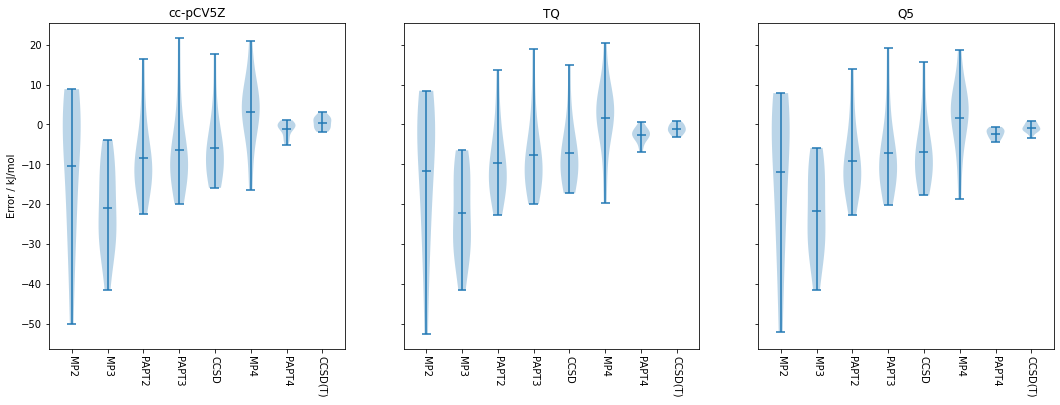

In [16]:
methods_pruned = methods[1:]
bases_pruned = ['cc-pCV5Z','TQ','Q5']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18,6))

for pane in range(len(bases_pruned)):
    data=[]
    for method in methods_pruned:
        data.append(list(error_with_respect_to_experimental_enthalpy[bases_pruned[pane]][method].values()))
    panes[pane].violinplot(data,showmeans=True,showextrema=True,vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1,len(methods_pruned)+1),labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name+".violin.pdf")

### Mean error

In [17]:
def error(method, basis, name):
    return Molpro_enthalpy[method][basis][name]-Exp_enthalpy[name]

lit_exp_molpro_error={}
for name in reactions:
    lit_exp_molpro_error[name]={}
    for method in methods:
        lit_exp_molpro_error[name][method]={}
        for basis in bases:
            lit_exp_molpro_error[name][method][basis]={}
            test_enthalpy = Molpro_enthalpy[method][basis][name]
            comparison_enthalpy = Exp_enthalpy[name]
            error = test_enthalpy - comparison_enthalpy
            lit_exp_molpro_error[name][method][basis] =+ error

lit_exp_molpro_meanerror={}
for method in methods:
    lit_exp_molpro_meanerror[method]={}
    for basis in bases:
        lit_exp_molpro_meanerror[method][basis]={}
        error_sum = 0
        for name in reactions:
            error_sum += lit_exp_molpro_error[name][method][basis]
        mean_error = error_sum / len(reactions)
        lit_exp_molpro_meanerror[method][basis] =+ mean_error

In [18]:
df_exp_reaction_meanerror=pd.DataFrame(data=lit_exp_molpro_meanerror)
df_exp_reaction_meanerror.style.set_caption("Mean error")

,HF,MP2,MP3,PAPT2,PAPT3,CCSD,MP4,PAPT4,CCSD(T)
cc-pCVDZ,14.954478,22.200433,8.575777,22.267072,22.849594,25.402670,35.419057,32.630359,33.394146
cc-pCVTZ,13.322459,0.327119,-11.892328,1.374548,3.034337,4.473136,14.121807,9.731302,11.312945
cc-pCVQZ,10.726128,-7.638902,-18.943071,-6.035254,-4.216551,-3.319223,5.858537,1.457899,3.021306
cc-pCV5Z,9.248854,-10.493184,-21.000155,-8.265233,-6.373969,-5.780421,3.064909,-1.120281,0.386272
DT,13.322459,-8.195532,-19.823311,-6.735138,-4.621762,-3.652133,5.841709,0.776760,2.702763
TQ,10.726128,-11.557325,-22.193589,-9.547787,-7.613121,-7.110920,1.723203,-2.684830,-1.134730
Q5,9.248854,-11.937913,-21.608479,-9.054957,-7.087563,-6.812735,1.683817,-2.275329,-0.828425


### Mean absolute error

In [19]:
lit_exp_molpro_abserror={}
for name in reactions:
    lit_exp_molpro_abserror[name]={}
    for method in methods:
        lit_exp_molpro_abserror[name][method]={}
        for basis in bases:
            lit_exp_molpro_abserror[name][method][basis]={}
            test_enthalpy = Molpro_enthalpy[method][basis][name]
            comparison_enthalpy = Exp_enthalpy[name]
            error = abs(test_enthalpy - comparison_enthalpy)
            lit_exp_molpro_abserror[name][method][basis] =+ error


lit_exp_molpro_meanabserror={}
for method in methods:
    lit_exp_molpro_meanabserror[method]={}
    for basis in bases:
        lit_exp_molpro_meanabserror[method][basis]={}
        error_sum = 0
        for name in reactions:
            error_sum += lit_exp_molpro_abserror[name][method][basis]
        mean_error = error_sum / len(reactions)
        lit_exp_molpro_meanabserror[method][basis] =+ mean_error

In [20]:
df_exp_reaction_meanabserror=pd.DataFrame(data=lit_exp_molpro_meanabserror)
df_exp_reaction_meanabserror.style.set_caption("Mean absolute error")

,HF,MP2,MP3,PAPT2,PAPT3,CCSD,MP4,PAPT4,CCSD(T)
cc-pCVDZ,29.772647,30.990673,17.228731,29.134130,29.668345,30.847099,38.415537,36.650477,36.734393
cc-pCVTZ,28.674379,13.738105,12.199806,8.108017,8.763968,7.859615,16.361433,11.236887,12.047097
cc-pCVQZ,29.135419,13.486257,18.943071,9.835248,9.373149,7.361378,9.359350,3.146428,3.704045
cc-pCV5Z,29.056404,14.456410,21.000155,11.505386,10.922044,9.371626,7.308601,1.378161,1.304581
DT,28.674379,12.390998,19.823311,10.435913,9.908778,7.616045,10.281158,4.105216,4.374121
TQ,29.135419,14.762806,22.193589,11.999932,11.396504,9.940689,6.929504,2.774753,1.327139
Q5,29.056404,15.418960,21.608479,11.714145,11.103542,9.934693,7.034897,2.275329,1.185635


### Maximum error

In [21]:
lit_exp_molpro_maxerror={}
for method in methods:
    lit_exp_molpro_maxerror[method]={}
    for basis in bases:
        lit_exp_molpro_maxerror[method][basis]={}
        max_error = 0
        for name in reactions:
            if abs(lit_exp_molpro_error[name][method][basis]) > abs(max_error):
                max_error = lit_exp_molpro_error[name][method][basis]
        lit_exp_molpro_maxerror[method][basis] =+ max_error

In [22]:
df_exp_reaction_maxerror=pd.DataFrame(data=lit_exp_molpro_maxerror)
df_exp_reaction_maxerror.style.set_caption("Maximum error")

,HF,MP2,MP3,PAPT2,PAPT3,CCSD,MP4,PAPT4,CCSD(T)
cc-pCVDZ,115.100379,76.538149,-34.352163,48.968055,48.412690,51.596283,85.940386,64.510810,65.916791
cc-pCVTZ,112.330648,-44.426818,-26.223071,24.635398,29.197598,24.350267,41.332397,19.441841,21.327717
cc-pCVQZ,113.180763,-48.754143,-37.370032,18.575804,23.542680,19.282486,26.725887,-5.960171,6.971901
cc-pCV5Z,113.659947,-50.009164,-41.355025,-22.475486,21.642531,17.724047,20.766190,-5.072136,2.999326
DT,112.330648,-49.478559,-41.352669,-21.804489,24.214225,19.850477,24.174609,11.947065,10.788612
TQ,113.180763,-52.532276,-41.498754,-22.640761,-19.891997,-17.214768,20.390657,-6.881558,-3.147673
Q5,113.659947,-51.828657,-41.439529,-22.759090,-20.037758,-17.750383,-18.711710,-4.336995,-3.490838


### Standard deviation

In [23]:
lit_exp_molpro_std={}
for method in methods:
    lit_exp_molpro_std[method]={}
    for basis in bases:
        lit_exp_molpro_std[method][basis]={}
        sum_squared_errors = 0
        for name in reactions:
            squared_error = (lit_exp_molpro_error[name][method][basis] - lit_exp_molpro_meanerror[method][basis]) ** 2
            sum_squared_errors += squared_error
        SD_squared = sum_squared_errors / (len(reactions)-1)
        SD = np.sqrt(SD_squared)
        lit_exp_molpro_std[method][basis] = SD

In [24]:
df_exp_reaction_std=pd.DataFrame(data=lit_exp_molpro_std)
df_exp_reaction_std.style.set_caption("Standard deviation of errors")

,HF,MP2,MP3,PAPT2,PAPT3,CCSD,MP4,PAPT4,CCSD(T)
cc-pCVDZ,39.456751,31.145927,18.676899,23.014348,23.160847,22.608315,30.928521,26.504015,25.921443
cc-pCVTZ,39.034716,19.528758,9.119990,10.514403,11.225939,9.027575,14.497921,8.457648,8.067539
cc-pCVQZ,40.602684,18.267680,10.140804,9.835798,10.617218,8.654956,10.441652,3.303437,2.880693
cc-pCV5Z,41.238203,18.168890,11.048318,10.112304,10.884534,9.204159,9.145103,1.833756,1.508516
DT,39.034716,16.854376,12.314934,11.300724,11.888249,9.305779,10.616360,5.928093,4.828084
TQ,40.602684,18.420419,10.969529,9.620094,10.357727,8.747805,9.586242,1.925383,1.228557
Q5,41.238203,18.701941,10.989039,9.599705,10.372099,9.036057,9.135722,1.254658,1.217626


In [25]:
with open(project_name+'.tex','w') as tf:
    tf.write('\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}')
    tf.write(df_exp_reaction_meanerror.style.to_latex())
    tf.write(df_exp_reaction_std.style.to_latex())
    tf.write(df_exp_reaction_meanabserror.style.to_latex())
    tf.write(df_exp_reaction_maxerror.style.to_latex())